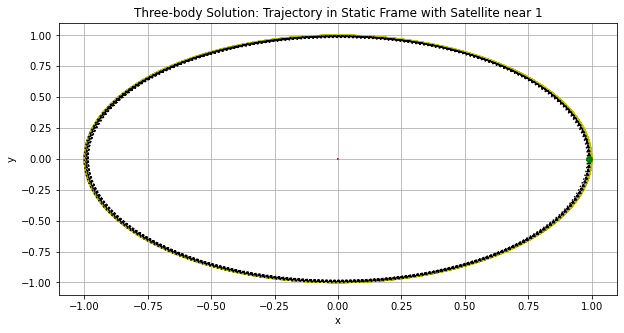

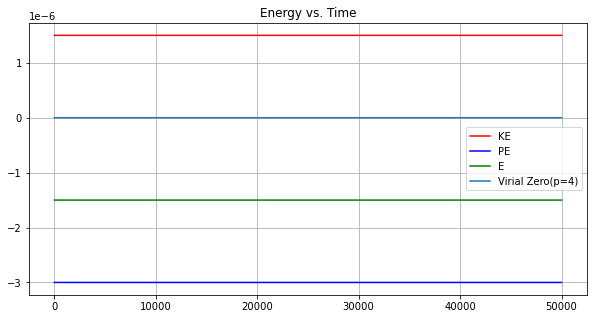

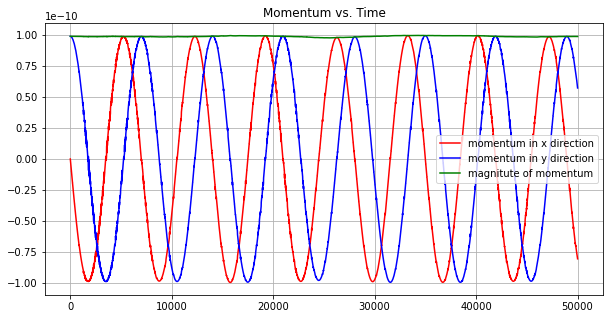

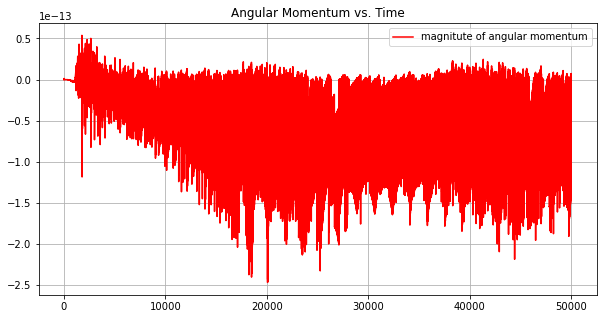

In [1]:
# Using Modification
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import odeint
import math
import copy

G = 1.0
w = 1
M_s = 1.0/(1.0 + 3.0e-6) 
M_e = 1.0 - M_s
M_sat = 1e-10
mu_s = G * M_s
mu_e = G * M_e
R_s = mu_e
R_e = mu_s


def calcEnergy(y:np.array):

    vs = np.sqrt(y[2]**2 + y[3]**2)    # Velocity of Sun
    ve = np.sqrt(y[6]**2 + y[7]**2)    # Velocity of Earth
    vsat = np.sqrt(y[10]**2 + y[11]**2)  # Velocity of Satellite

    dse = np.sqrt((y[4]-y[0])**2 + (y[5]-y[1])**2) # Sun-Earth Distance
    dssat = np.sqrt((y[8]-y[0])**2 + (y[9]-y[1])**2) # Sun-Satellite Distance
    desat = np.sqrt((y[8]-y[4])**2 + (y[9]-y[5])**2) # Earth-Satellite Distance

    Ek = 0.5*M_s*vs**2 + 0.5*M_e*ve**2 + 0.5*M_sat*vsat**2 # Total Kinetic Energy
    Ep = - G*M_e*M_s/dse - G*M_s*M_sat/dssat - G*M_e*M_sat/desat # Total Gravitational Potential Energy
    Ee = Ek + Ep # Total Energy

    return Ek, Ep, Ee

def calcMomentum(y:np.array):

    Px = M_s * y[2] + M_e * y[6] + M_sat * y[10] # Total Momentum in x direction
    Py = M_s * y[3] + M_e * y[7] + M_sat * y[11] # Total Momentum in y direction
    
    return Px,Py

def calcAngMomentum(y:np.array):

    # Magnitude of angular momentum = m*(x*vy - y*vx) as calculated from cross product r x p
    Am_s = (y[0]*y[3] - y[1]*y[2]) * M_s # Angular Momentum of Sun
    Am_e = (y[4]*y[7] - y[5]*y[6]) * M_e # Angular Momentum of Earth
    Am_p = (y[8]*y[11] - y[9]*y[10]) * M_sat # Angular Momentum of Satellite
    Am = Am_s + Am_e + Am_p # Total Angular Momentum (algebraic sum because all angular momentum are in the same direction)
    
    return Am

def L_s(y:np.array, t: float, mu_s, mu_e):
    dy = np.zeros(12)

    acc_s = mu_e  # Mag of Acc by Earth on Sun
    a_s = np.arctan2(y[1], y[0]) + np.pi # alpha the angle of gravititional force on Sun
    dy[0] = y[2]          # Svx
    dy[1] = y[3]          # Svy
    dy[2] = acc_s * np.cos(a_s) # Sax
    dy[3] = acc_s * np.sin(a_s) # Say

    acc_e = mu_s  # Mag of Acc by Sun on Earth
    a_e = np.arctan2(y[5], y[4]) + np.pi # alpha the angle of gravititional force
    dy[4] = y[6]          # Evx
    dy[5] = y[7]          # Evy
    dy[6] = acc_e * np.cos(a_e) # Eax
    dy[7] = acc_e * np.sin(a_e) # Eay   

    acc_s_sat = mu_s / ((y[8]-y[0])**2 + (y[9]-y[1])**2) # Mag of Acc by Sun on Satellite
    acc_e_sat = mu_e / ((y[8]-y[4])**2 + (y[9]-y[5])**2) # Mag of Acc by Earth on Satellite    
    a_s_sat = np.arctan2(y[9]-y[1], y[8]-y[0])  + np.pi#  the angle of gravititional force by Sun on Satellite
    a_e_sat = np.arctan2(y[9]-y[5], y[8]-y[4])  + np.pi#  the angle of gravititional force by Earth on Satellite
    dy[8] = y[10]          # vx
    dy[9] = y[11]          # vy
    dy[10] = acc_s_sat * np.cos(a_s_sat) + acc_e_sat * np.cos(a_e_sat) # ax
    dy[11] = acc_s_sat * np.sin(a_s_sat) + acc_e_sat * np.sin(a_e_sat) # ay 

    return dy

def initState(lag_id = 5):
    
    y0 = np.zeros(12) # four parameters for three objects - Sun, Earth, Satellite

    # initial states - Sun
    y0[0] = -R_s
    y0[1] = 0
    y0[2] = 0
    y0[3] = -w*R_s
    # initial states - Earth
    y0[4] = R_e
    y0[5] = 0
    y0[6] = 0
    y0[7] = w*R_e

    Lag = lag_id
    if Lag == 1:
        y0[8] = (1 - (mu_e/3)**(1/3))              # x0
        y0[9] = 0.0                                # y0
    elif Lag == 2:
        y0[8] = (1 + (mu_e/3)**(1/3))              # x0
        y0[9] = 0.0                                # y0
    elif Lag == 3:
        y0[8] = -(1 + 5/12*mu_e)                   # x0
        y0[9] = 0.0                                # y0
    elif Lag == 4:
        y0[8] = 0.5 * (mu_s-mu_e)                  # x0
        y0[9] = np.sqrt(3)/2                       # y0
    elif Lag == 5:
        y0[8] = 0.5*(mu_s-mu_e)                    # x0
        y0[9] = -np.sqrt(3)/2                      # y0
    else: # Based on L5, random disturbance
        y0[8] = 0.5*(mu_s-mu_e) + np.random.random()*0.1      # x0
        y0[9] = -np.sqrt(3)/2                      # y0

    a_sat = np.arctan2(y0[9],y0[8])                # angle of satellite from COM
    v_sat = w * np.sqrt(y0[8]**2 + y0[9]**2)       # linear velocity of satellite
    y0[10] = v_sat * np.cos(a_sat + np.pi/2)       # Horizontal Initial Velocity                          
    y0[11] = v_sat * np.sin(a_sat + np.pi/2)       # Vertical Initial velocity

    return y0

def modifyState(y, y0):
    # sun - just send back to original path with correct velocity
    alpha_s = np.arctan2(y[1], y[0])
    y[0] = R_s * np.cos(alpha_s)
    y[1] = R_s * np.sin(alpha_s)
    y[2] = w*R_s * np.cos(alpha_s + math.pi/2)
    y[3] = w*R_s * np.sin(alpha_s + math.pi/2)

    # earth - just send back to original path with correct velocity
    alpha_e = np.arctan2(y[5], y[4])
    y[4] = R_e * np.cos(alpha_e)
    y[5] = R_e * np.sin(alpha_e)
    y[6] = w*R_e * np.cos(alpha_e + math.pi/2)
    y[7] = w*R_e * np.sin(alpha_e + math.pi/2)

    # modify velocity vector
    Ek_0, Ep_0, Ee_0 = calcEnergy(y0) # Initial Energy - Needs to be conserved
    Am_0 = calcAngMomentum(y0)        # Initial Angular Momentum - Needs to be conserved
    best_err = 1e10                  # The starting error of our approaching
    best_y = copy.deepcopy(y)         # Modification of the current y after the previous section. Copied to avoid overwriting in other simulations.
    for i in range(-20, 20):          # Both increase and decrement of velocity is possible
        for j in range(-20, 20):      # Two dimensions in total
            y_test = copy.deepcopy(y) # 1600 tests in total
            y_test[10] = y[10] + i * 0.1/20 # Horizontal velocity is modified for testing
            y_test[11] = y[11] + j * 0.1/20 # Vertical velocity is modified for testing

            Ek_t, Ep_t, Ee_t = calcEnergy(y_test) # After modification, what is the energy?
            Am_t = calcAngMomentum(y_test)        # After modification, what is the angular momentum?
            err = abs(Ee_t-Ee_0) + abs(Am_t-Am_0) # The absolute deviation from the initial values
            if err < best_err:                    # This will locate the delta v with smallest error
                best_err = err
                best_y = copy.deepcopy(y_test)
    
    return best_y

def runSim(y0, end_t, total_step, section_step):

    tlist = np.linspace(0.0, end_t, total_step)
    total_section = round(total_step/section_step)

    yt = copy.deepcopy(y0)
    sol_sat = np.zeros((total_step, y0.shape[0]))
    for e in range(total_section):    # iteratio section by section
        # step 1: odeint
        sol_section = odeint(L_s, yt, tlist[e*section_step:(e+1)*section_step], rtol=1e-10, args = (mu_s, mu_e))
        # step 2: store
        sol_sat[e*section_step:(e+1)*section_step] = sol_section
        # step 3: modify y_init
        yt = modifyState(sol_section[-1], y0)
    
    res_Ek = np.zeros(total_step) # same as before
    res_Ep = np.zeros(total_step)
    res_Ee = np.zeros(total_step)
    res_Mx = np.zeros(total_step)
    res_My = np.zeros(total_step)
    res_Am = np.zeros(total_step)
    for i in range(total_step):
        res_Ek[i], res_Ep[i], res_Ee[i] = calcEnergy(sol_sat[i])
        res_Mx[i], res_My[i] = calcMomentum(sol_sat[i])
        res_Am[i] = calcAngMomentum(sol_sat[i])

    return tlist, sol_sat, [res_Ek, res_Ep, res_Ee], [res_Mx, res_My], res_Am

if __name__ == '__main__': # Same as unmodified simulation

    end_t = 50.0
    total_step = 50000
    section_step = 10 # The number of steps each section. After each section, one modification is done.
    lag_id = 1 # lagrange point 
    
    y0 = initState(lag_id)

    tlist, Lag_sol, lag_En, lag_Mo, lag_Am = runSim(y0, end_t, total_step, section_step)
    Virial_list = lag_En[0] + 0.5*lag_En[1]
    Mo_list = np.sqrt(lag_Mo[0]**2 + lag_Mo[1]**2)


    plt.figure(figsize=(10,5))
    plt.title(f'Three-body Solution: Trajectory in Static Frame with Satellite near {lag_id}')
    plt.plot(Lag_sol[:, 0],Lag_sol[:, 1], '-r')   # Sun
    plt.plot(Lag_sol[:, 4],Lag_sol[:, 5], '-y')   # Earth
    plt.plot(Lag_sol[:, 8],Lag_sol[:, 9], ':k')   # Satellite
    plt.plot(Lag_sol[0, 8],Lag_sol[0, 9], 'go')   # Starting point of satellite          
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

    plt.figure(figsize=(10,5))
    plt.title('Energy vs. Time')
    plt.plot(lag_En[0], '-r', label='KE')
    plt.plot(lag_En[1], '-b', label='PE')
    plt.plot(lag_En[2], '-g', label='E')
    plt.plot(Virial_list, label='Virial Zero(p=4)')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(10,5))
    plt.title('Momentum vs. Time')
    plt.plot(lag_Mo[0], '-r', label='momentum in x direction')
    plt.plot(lag_Mo[1], '-b', label='momentum in y direction')
    plt.plot(Mo_list, '-g', label='magnitute of momentum')
    plt.legend()
    plt.grid()

    plt.figure(figsize=(10,5))
    plt.title('Angular Momentum vs. Time')
    plt.plot(lag_Am-lag_Am[0], '-r',label='magnitute of angular momentum')
    plt.legend()
    plt.grid()